# Model dimensionality and overfitting
This notebook provides a simple example of how model of increasing dimensionality will necessarily overfit when evaluated "in-sample"—in the same sample they model is trained on (e.g., [Yarkoni & Westfall, 2017](https://doi.org/10.1177/1745691617693393)). To make the point, the model features `X` and the target variable `y` are constructed from random normal vectors (i.e. noise). This effect persists for both OLS and ridge regression, and is rectified by using out-of-sample prediction (cross-validation).

In [1]:
import numpy as np
from scipy.stats import ttest_1samp, wilcoxon, zscore
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

First we assess R-squared for models of increasing dimensionality. Models are trained and tested in the same sample. R-squared model performance increases monotonically with model dimensionality. The more features the model has, the better it can fit random noise in the sample—even when both model and target are random noise.

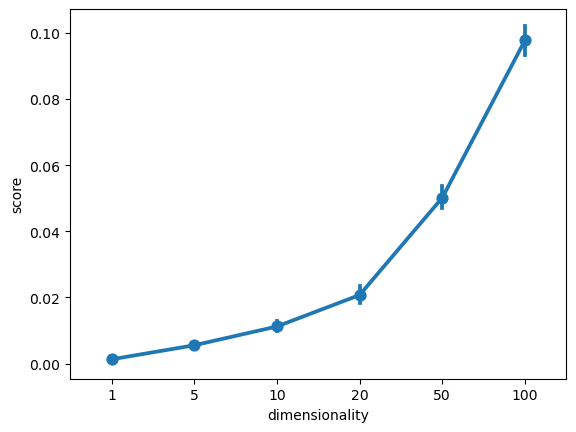

In [2]:
n_repetitions = 30
n_samples = 1000
feature_grid = [1, 5, 10, 20, 50, 100]

np.random.seed(1312)
y = np.random.randn(n_samples)

model = LinearRegression()

results = {'dimensionality': [], 'score': []}
for n_features in feature_grid:

    for repeat in np.arange(n_repetitions):
        X = np.random.randn(n_samples, n_features)
        model.fit(X, y)
        y_pred = model.predict(X)
        score = r2_score(y, y_pred)
        results['dimensionality'].append(n_features)
        results['score'].append(score)

results_df = pd.DataFrame(results)
sns.pointplot(x='dimensionality', y='score', data=results_df);

Next, we use a ridge regression model with a default ridge coefficient of 1. Although this model will introduce some (arbitrary) level of regularization, it still overfits the training sample. 

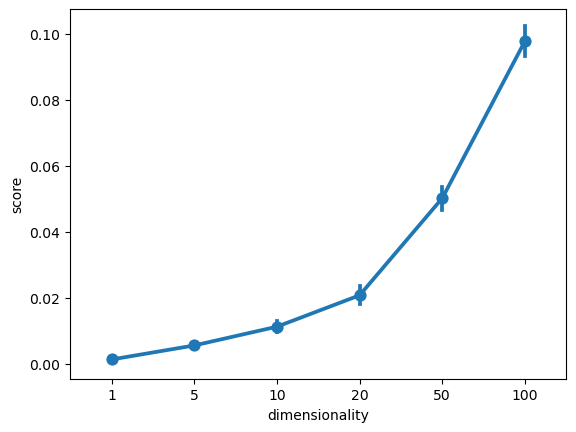

In [3]:
n_repetitions = 30
n_samples = 1000
feature_grid = [1, 5, 10, 20, 50, 100]

np.random.seed(1312)
y = np.random.randn(n_samples)

# Ridge with default penalty of 1
model = Ridge(alpha=1)

results = {'dimensionality': [], 'score': []}
for n_features in feature_grid:

    for repeat in np.arange(n_repetitions):
        X = np.random.randn(n_samples, n_features)
        model.fit(X, y)
        y_pred = model.predict(X)
        score = r2_score(y, y_pred)
        results['dimensionality'].append(n_features)
        results['score'].append(score)

results_df = pd.DataFrame(results)
sns.pointplot(x='dimensionality', y='score', data=results_df);

Now we introduce a simple cross-validation scheme to ensure the model is trained on a subset of the dataset and evaluated on a non-overlaping test set. In this scenario, the high-dimensional models actually yield *worse* generalization performance due to overfitting the training sets.

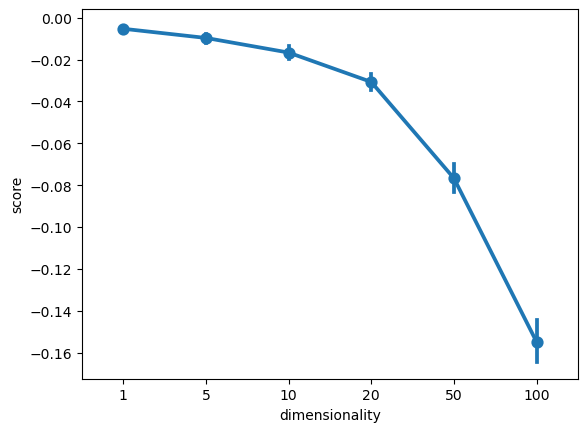

In [4]:
n_repetitions = 30
n_samples = 1000
feature_grid = [1, 5, 10, 20, 50, 100]

np.random.seed(1312)
y = np.random.randn(n_samples)

# Ridge with default penalty of 1
model = Ridge(alpha=1)

# Simple cross-validation procedure
cv = KFold(n_splits=5)

results = {'dimensionality': [], 'score': []}
for n_features in feature_grid:

    for repeat in np.arange(n_repetitions):
        X = np.random.randn(n_samples, n_features)

        for train, test in cv.split(X):
            model.fit(X[train], y[train])
            y_pred = model.predict(X[test])
            score = r2_score(y[test], y_pred)
            results['dimensionality'].append(n_features)
            results['score'].append(score)

results_df = pd.DataFrame(results)
sns.pointplot(x='dimensionality', y='score', data=results_df);

Let's go back to the "in-sample" version and get the largest difference between randomizations at each dimensionlity.

Text(0, 0.5, 'maximum difference between randomizations')

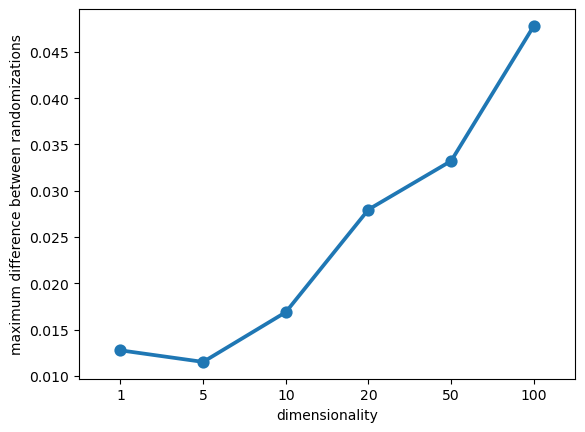

In [5]:
n_repetitions = 30
n_samples = 1000
feature_grid = [1, 5, 10, 20, 50, 100]

np.random.seed(1312)
y = np.random.randn(n_samples)

model = Ridge(alpha=1)

results = {'dimensionality': [], 'score': []}
for n_features in feature_grid:

    for repeat in np.arange(n_repetitions):
        X = np.random.randn(n_samples, n_features)
        model.fit(X, y)
        y_pred = model.predict(X)
        score = r2_score(y, y_pred)
        results['dimensionality'].append(n_features)
        results['score'].append(score)

results_df = pd.DataFrame(results)
diff_df = (results_df.groupby('dimensionality')['score'].max() -
           results_df.groupby('dimensionality')['score'].min()
          ).abs().to_frame()
sns.pointplot(x='dimensionality', y='score', data=diff_df)
plt.ylabel('maximum difference between randomizations')

Lastly, let's re-run one version of the model with 50 repetitions and try to assess statistical significance of the R-squared values.

In [6]:
n_repetitions = 50
n_samples = 1000
n_features = 50

np.random.seed(1312)
y = np.random.randn(n_samples)

model = Ridge(alpha=1)

scores = []
for repeat in np.arange(n_repetitions):
    X = np.random.randn(n_samples, n_features)
    model.fit(X, y)
    y_pred = model.predict(X)
    score = r2_score(y, y_pred)
    scores.append(score)

Because R-squared values can only be positive, parametric or nonparametric one-sample tests will be trivially "significant".

Parametric t = 38.199, p = 0.00000
Nonparametric p = 0.00000


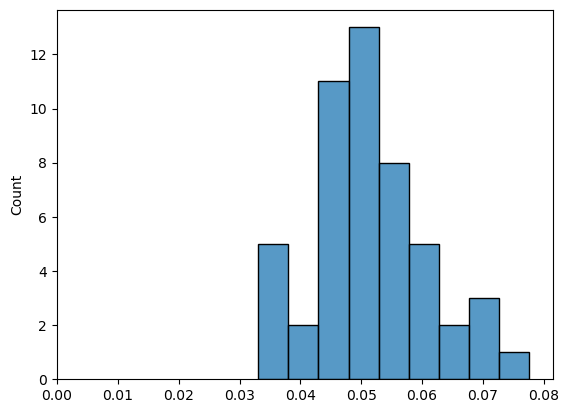

In [7]:
xlim_upper = 1.05 * np.max(scores)
xlim_lower = 1.05 * np.min(scores) if np.min(scores) < 0 else 0

fig, ax = plt.subplots()
sns.histplot(scores)
ax.set_xlim(xlim_lower, xlim_upper);

t, p = ttest_1samp(scores, popmean=0)
_, pw = wilcoxon(scores)

print(f"Parametric t = {t:.3f}, p = {p:.5f}")
print(f"Nonparametric p = {pw:.5f}")

After z-scoring, there will not be any effect of the mean.

Parametric t = -0.000, p = 1.00000
Nonparametric p = 0.67363


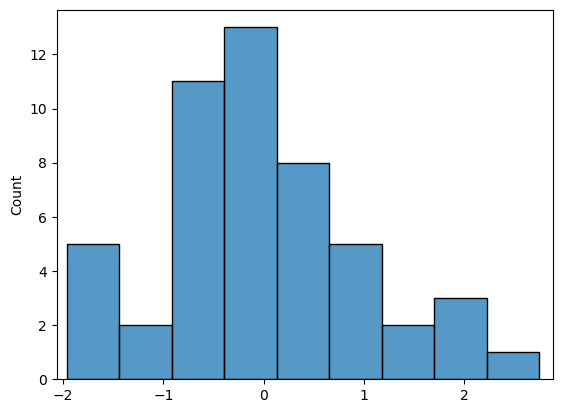

In [8]:
scores_z = zscore(scores)
xlim_upper = 1.05 * np.max(scores_z)
xlim_lower = 1.05 * np.min(scores_z) if np.min(scores_z) < 0 else 0

fig, ax = plt.subplots()
sns.histplot(scores_z);
ax.set_xlim(xlim_lower, xlim_upper);

t, p = ttest_1samp(scores_z, popmean=0)
_, pw = wilcoxon(scores_z)

print(f"Parametric t = {t:.3f}, p = {p:.5f}")
print(f"Nonparametric p = {pw:.5f}")

### References
Yarkoni, T., & Westfall, J. (2017). Choosing prediction over explanation in psychology: Lessons from machine learning. *Perspectives on Psychological Science*, *12*(6), 1100-1122. https://doi.org/10.1177/1745691617693393